In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import datetime
import warnings 
warnings.filterwarnings('ignore')

# Read application, response and behavior data. Merge applications data with response

In [3]:
application_data = pd.read_csv('appl_data.csv')
behave_on_site = pd.read_csv('behav_on_site.csv')
response = pd.read_csv('is_default.csv')

X = pd.merge(left = application_data, right = response, how='left', on='appl_id')

print X.shape
print "Number of unique applicants - {}".format(X.client_id.unique().shape[0])
X.head()

(8084, 24)
Number of unique applicants - 8084


,appl_id,app_crtime,client_id,birth,gender,pass_bdate,fam_status,quantity_child,max_age_child,property,...,jobsworksince,work_experience,empl_state,empl_type,empl_worker_count,education_area,education,monthlyincome,monthlycost,df
0,1157589,2017-12-31T09:35:53Z,119804,1994-01-12,1,2010-10-08,4,1,3.0,5,...,NaN,3,4,NaN,NaN,7.0,2,15000.0,10000.0,NaN
1,1159012,2017-12-31T20:05:37Z,120147,1994-02-14,2,2010-04-06,4,0,0.0,5,...,2013-05-01,4,1,6.0,1.0,NaN,6,8000.0,6000.0,NaN
2,1157375,2017-12-31T08:18:56Z,119755,1984-10-20,2,2013-06-28,3,1,2.0,5,...,2015-12-01,10,1,10.0,6.0,6.0,7,15000.0,14000.0,NaN
3,1158541,2017-12-31T15:18:23Z,120042,1986-02-07,2,2012-09-27,4,0,0.0,5,...,2017-09-01,13,1,1.0,5.0,6.0,2,10000.0,5000.0,NaN
4,1157949,2017-12-31T11:25:38Z,119893,1992-06-26,2,2012-02-11,4,0,0.0,1,...,2014-08-01,3,1,10.0,5.0,3.0,1,7500.0,5000.0,NaN


In [5]:
def index_client_behav_data(application_data,behave_on_site, client_id):
    "Select behav_on_site data (before the application date) given client id "
    
    application_date = application_data[application_data.client_id == client_id].app_crtime.iloc[-1]
    
    filt_ = ( (behave_on_site.client_id == client_id) &
                (behave_on_site.create_time <= application_date) )
    
    x = behave_on_site[ filt_ ].sort_values('create_time').reset_index(drop = True)
    x.create_time = pd.to_datetime(x.create_time)
    
    return x

def label_sessions(x):
    '''Define session - sequence of users website actions using same browser,
       device and and platform separeted no more than 15 minutes.
       Create action -> session mapping '''
    
    td = x.create_time.diff() > pd.datetools.timedelta(minutes = 15)
    browser = x.browser != x.browser.shift()
    platform = x.platform != x.platform.shift()
    device = x.device_id != x.device_id.shift()
    x['session_id'] = (td | browser | platform | device).cumsum()
    return x


def get_session_duration(x):
    '''Calculate user website session duration'''
    
    start = min(x.create_time)
    end = max(x.create_time)
    duration_min = (end - start) / np.timedelta64(1, 'm')
    return duration_min


def get_platform_duration(application_data,behave_on_site,client_id):
    'Calculates spent time distribution between platform ( for given client id) '
    
    platforms = behave_on_site.platform.unique()
    platform_duration = dict(zip(platforms,np.zeros(platforms.shape[0])))
    x = index_client_behav_data(application_data, behave_on_site, client_id)
    label_sessions(x)
    for id_ in x.session_id.unique():
        tmp = x[x.session_id == id_]
        platform_duration[x.platform[0]] += get_session_duration(tmp)
    return platform_duration


def get_browser_duration(application_data,behave_on_site,client_id):
    'Calculates spent time distribution between browsers (for given client id) '
    
    browsers = behave_on_site.browser.unique()
    browser_duration = dict(zip(browsers,np.zeros(browsers.shape[0])))
    x = index_client_behav_data(application_data, behave_on_site, client_id)
    label_sessions(x)
    for id_ in x.session_id.unique():
        tmp = x[x.session_id == id_]
        browser_duration[x.browser[0]] += get_session_duration(tmp)
    return browser_duration


def get_n_sessions(application_data, behave_on_site, client_id):
    "Calculates number of website sessions for given client_id"
    
    x = index_client_behav_data(application_data, behave_on_site, client_id)
    label_sessions(x)
    return x.session_id.unique().shape[0]




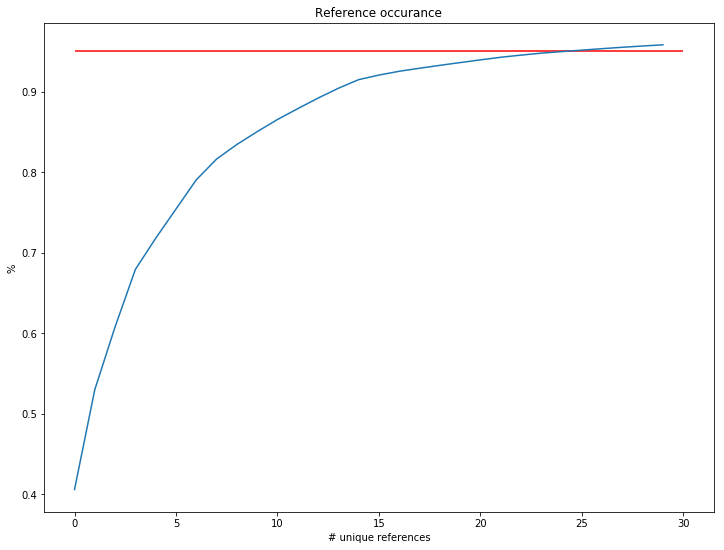

'As we can see 25 most frequent refs represent approx 95% of all references\n   To avoid very sparse representation i will use only this 25 refs\n   '

In [34]:
'''I am convinced that uses transitions sequence can express useful behavioral
   patterns and related to users response. Thats why it is important to model transitions in right way. 
   I think that  structured probabilistic models like graph or marcov chain can deal with it. 
   Another option is to use NLP approaches like word2vec to map transitions sequence to some embedding space.
   Such way is good not only for mapping inputs to same dimension but also for learning transitions semantic.
   These ideas require lot of data, time and struggling on the way to fit it. 
   So i will use very simple approach:
   1) Choose only 95% of most frequent refs
   2) Create refs vocalbury - {'reference' : position }
   3) create reference vector - count number of occurances for each reference and put this number 
   on position based on vocalbury. This vector will be my representation of user transitions on website
   '''

plt.figure(figsize = (12,9))
plt.title('Reference occurance')
plt.ylabel('%')
plt.xlabel('# unique references')
percentage = (behave_on_site.id_ref.value_counts().cumsum() / behave_on_site.shape[0])[:30].values
plt.plot(range(percentage.shape[0]), percentage)
plt.hlines(0.95, 0, 30, color = 'red')
plt.show()

'''As we can see 25 most frequent refs represent approx 95% of all references
   To avoid very sparse representation i will use only this 25 refs
   '''

In [50]:
REFS = behave_on_site.id_ref.value_counts()[:25].index.values
REFS_VOCAB = dict(zip(REFS, range(REFS.shape[0])))

def create_refs_vector(application_data,behave_on_site, client_id):
    '''Create reference vector for given client_id'''    
    
    refs_vector = np.zeros(REFS.shape[0])
    x = index_client_behav_data(application_data,behave_on_site, client_id)
    for ref in x.id_ref.values:
        if ref in REFS:
            refs_vector[ REFS_VOCAB[ref] ] +=1
        else:
            continue
    return refs_vector

In [51]:
def get_info(application_data, behave_on_site, client_id):
    '''
       This method return information about all website behavoiur for given client id
       using all functions defined above
    '''
    
    info = {}
    
    info['client_id'] = client_id
    
    info['application_id'] = application_data[application_data.client_id == client_id].appl_id.iloc[0]
    
    info['n_sessions'] = get_n_sessions(application_data, behave_on_site, client_id)
    
    info['platform_duration'] = get_platform_duration(application_data, behave_on_site, client_id)
    
    info["browser_duration"] = get_browser_duration(application_data, behave_on_site, client_id)
    
    info['ref_vector'] = create_refs_vector(application_data, behave_on_site, client_id)
    
    return info

In [52]:
info = [ get_info(application_data, behave_on_site, client_id) 
                                 for client_id in X.client_id]

behav_info = pd.DataFrame(info)

# Time spent on website per browser

In [ ]:
browser_duration = pd.DataFrame(list(behav_info.browser_duration.values))
plt.figure(figsize = (12,9))
plt.title('Total time spent on website per browser' )
plt.ylabel('Minutes')
browser_duration.apply(sum).plot(kind = 'bar')
browser_duration['favourite_browser'] = browser_duration.idxmax(axis =1)

plt.show()

In [ ]:
browser_duration['appl_id'] = behav_info['application_id']
browser_duration = pd.merge(left=browser_duration, right=response, how='left', on = 'appl_id')

In [ ]:
plt.figure(figsize = (12,9))
browser_duration.pivot_table('appl_id', 'favourite_browser', 'df', 'count').plot(kind = 'bar', stacked = True )
plt.show()

# Time spent on website per platform

In [ ]:
platform_duration = pd.DataFrame(list(behav_info.platform_duration.values))
plt.figure(figsize = (12,9))
plt.title('Total time spent on website per platform' )
plt.ylabel('Minutes')
platform_duration.apply(sum).plot(kind = 'bar')
plt.show()

# Number of website sessions and mean duration distributions

In [ ]:
plt.figure(figsize = (12,9))
plt.title('Distribution of number of website sessions')
plt.xlabel('# sessions')
plt.ylabel('count')
sns.distplot(behav_info.n_sessions, kde=False, bins = 50)
plt.show()


mean_duration = browser_duration.sum(axis = 1) / behav_info.n_sessions
plt.figure(figsize = (12,9))
plt.title('Distribution of session duration')
sns.distplot(mean_duration, kde=False)
plt.ylabel('Count')
plt.xlabel('Duration minutes')
plt.show()

In [ ]:
duration

In [ ]:
duration[0] / np.timedelta64(1, 'm') 

In [ ]:
x.create_time.sordiff() > pd.datetools.timedelta(minutes=5)

In [ ]:
len(set(zip(session_day,session_hour)))

In [ ]:
filt_ = (behave_on_site.client_id == X.client_id[123]) & (behave_on_site.create_time <= X.app_crtime[123]) 
x = behave_on_site[ filt_ ].sort_values('create_time').drop_duplicates(subset = 'create_time')
session_day = x.create_time.astype('datetime64[ns]').dt.day
session_hour = x.create_time.astype('datetime64[ns]').dt.hour
n_sessions = len(set(zip(session_day,session_hour)))

In [ ]:
client_id = X.client_id[0]
filt_ = ( (behave_on_site.client_id == client_id) & 
                (behave_on_site.create_time <= 
                    str(application_data[application_data.client_id == client_id].app_crtime.values[0])))


# Divide data into labeled part( train set) and unlabeled part (test set)

In [ ]:
plt.figure(figsize = (12,9))
plt.title('Response distribution')

sns.countplot(data.df)
plt.show()

In [ ]:
train = application_data[  application_data.df.notnull() ]
test = application_data[  application_data.df.isnull() ].drop('df',axis = 1)

print "Train data shape - {}".format(train.shape) 
print "Test data shape - {}".format(test.shape)

In [ ]:
sns.countplot(train.education_area)

# Missing values


In [ ]:
drops = ['appl_id','client_id','max_age_child', 'education_area', 'empl_type', 'empl_worker_count','jobsworksince']
x = train.drop(drops, axis = 1)
train.drop(drops, axis = 1).isna().sum() / train.shape[0]

# Datetimes

In [ ]:
dates = ['app_crtime', 'birth', 'pass_bdate', 'lived_since', 'is_same_reg_lived_since']
x[dates] = x[dates].apply(pd.to_datetime)

x['age'] = (x.app_crtime - x.birth).dt.days 

x['lived_since_days'] = (x.app_crtime - x.lived_since).dt.days 

x['reg_place_delta'] = (x.lived_since - x.is_same_reg_lived_since).dt.days

plt.figure(figsize = (12,9))
plt.title("Applicants age distribution")
sns.distplot(x.age, bins=20)
plt.show()


plt.figure(figsize = (12,9))
plt.title("Application hourly distribution")
sns.countplot(x.app_crtime.dt.hour.values, color = 'lightblue')
plt.show()

In [ ]:
categoricals = ['gender','region','region_reg', 'fam_status', 'empl_state']

ordinals = ['property','education']

numericals = ['quantity_child','work_experience','monthlyincome','monthlycost',
              'age','lived_since_days','reg_place_delta']

In [ ]:
c = pd.get_dummies(x[categoricals].astype('object')).reset_index(drop = True)
a = x[ordinals].reset_index(drop = True)

scaler = StandardScaler()
scaler.fit(x[numericals])

b = scaler.transform(x[numericals])
b = pd.DataFrame(b, columns = numericals)

b.head()

In [ ]:
train_df = pd.concat((a,b,c), axis = 1)

In [ ]:
lr = LogisticRegressionCV()
X,Y = train_df, x.df.apply(lambda x: int(x == 'good'))

X_train ,X_test, Y_train, Y_test = train_test_split(X,Y, stratify = Y)

rf = RandomForestClassifier(n_estimators = 1000, max_depth= 25)

In [ ]:
rf.fit(X_train, Y_train)

y_fitted = rf.predict(X_train)
print classification_report(Y_train,y_fitted)

In [ ]:
y_pred = rf.predict(X_test)
print classification_report(Y_test,y_pred)